In [2]:
%matplotlib inline

# Toy weather data

Here is an example of how to easily manipulate a toy weather dataset using xarray and other recommended Python libraries:

* Examine a dataset with pandas and seaborn
* Probability of freeze by calendar month
* Monthly averaging
* Calculate monthly anomalies
* Fill missing values with climatology

Shared setup:

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns # pandas aware plotting library

np.random.seed(123)

times = pd.date_range('2000-01-01', '2001-12-31', name='time')
annual_cycle = np.sin(2 * np.pi * (times.dayofyear / 365.25 - 0.28))

base = 10 + 15 * annual_cycle.reshape(-1, 1)
tmin_values = base + 3 * np.random.randn(annual_cycle.size, 3)
tmax_values = base + 10 + 3 * np.random.randn(annual_cycle.size, 3)

ds = xr.Dataset({'tmin': (('time', 'location'), tmin_values),
                 'tmax': (('time', 'location'), tmax_values)},
                {'time': times, 'location': ['IA', 'IN', 'IL']})

## Examine a dataset with pandas and seaborn

In [40]:
ds

<xarray.Dataset>
Dimensions:   (location: 3, time: 731)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
  * location  (location) <U2 'IA' 'IN' 'IL'
Data variables:
    tmax      (time, location) float64 12.98 3.31 6.779 0.4479 6.373 4.843 ...
    tmin      (time, location) float64 -8.037 -1.788 -3.932 -9.341 -6.558 ...

In [5]:
df = ds.to_dataframe()

In [6]:
df.head()

tmax       tmin
location time                            
IA       2000-01-01  12.980549  -8.037369
         2000-01-02   0.447856  -9.341157
         2000-01-03   5.322699 -12.139719
         2000-01-04   1.889425  -7.492914
         2000-01-05   0.791176  -0.447129

In [7]:
df.describe()

,tmax,tmin
count,2193.000000,2193.000000
mean,20.108232,9.975426
std,11.010569,10.963228
min,-3.506234,-13.395763
25%,9.853905,-0.040347
50%,19.967409,10.060403
75%,30.045588,20.083590
max,43.271148,33.456060


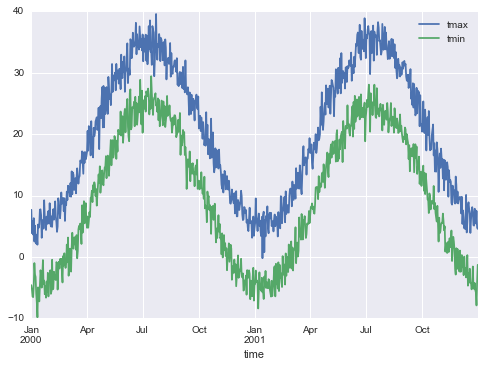

In [8]:
ds.mean(dim='location').to_dataframe().plot()

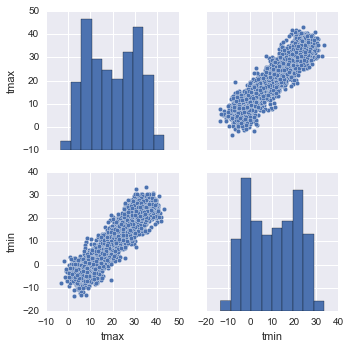

In [9]:
sns.pairplot(df.reset_index(), vars=ds.data_vars)

## Probability of freeze by calendar month

In [10]:
freeze = (ds['tmin'] <= 0).groupby('time.month').mean('time')

In [11]:
freeze

<xarray.DataArray 'tmin' (month: 12, location: 3)>
array([[ 0.9516129 ,  0.88709677,  0.93548387],
       [ 0.84210526,  0.71929825,  0.77192982],
       [ 0.24193548,  0.12903226,  0.16129032],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.01612903,  0.        ],
       [ 0.33333333,  0.35      ,  0.23333333],
       [ 0.93548387,  0.85483871,  0.82258065]])
Coordinates:
  * location  (location) <U2 'IA' 'IN' 'IL'
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

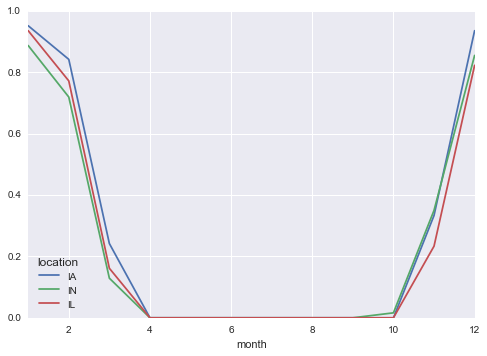

In [12]:
freeze.to_pandas().plot()

## Monthly averaging

In [13]:
monthly_avg = ds.resample('1MS', dim='time', how='mean')

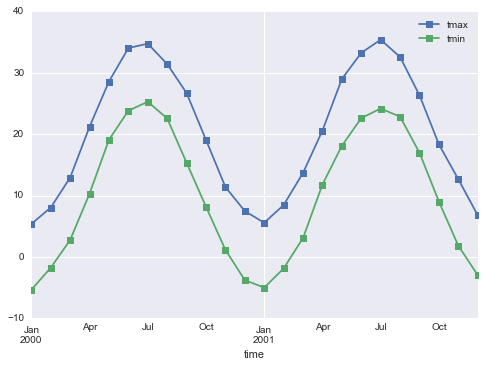

In [14]:
monthly_avg.sel(location='IA').to_dataframe().plot(style='s-')

Note that `MS` here refers to Month-Start; `M` labels Month-End (the last day of the month).

## Calculate monthly anomalies

In climatology, “anomalies” refer to the difference between observations and typical weather for a particular season. Unlike observations, anomalies should not show any seasonal cycle.

In [15]:
climatology = ds.groupby('time.month').mean('time')

In [16]:
anomalies = ds.groupby('time.month') - climatology

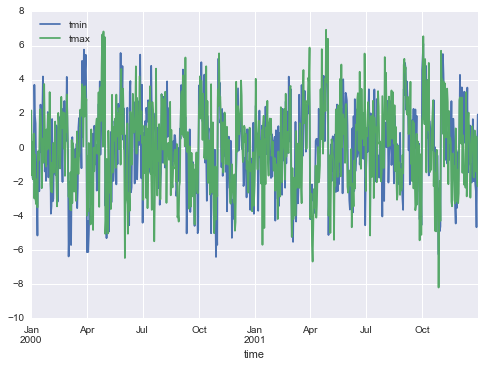

In [17]:
anomalies.mean('location').to_dataframe()[['tmin', 'tmax']].plot()

## Fill missing values with climatology

The `fillna()` method on grouped objects lets you easily fill missing values by group:

In [18]:
# throw away the first half of every month
some_missing = ds.tmin.sel(time=ds['time.day'] > 15).reindex_like(ds)

In [19]:
filled = some_missing.groupby('time.month').fillna(climatology.tmin)

In [20]:
both = xr.Dataset({'some_missing': some_missing, 'filled': filled})

In [21]:
both

<xarray.Dataset>
Dimensions:       (location: 3, time: 731)
Coordinates:
  * location      (location) <U2 'IA' 'IN' 'IL'
  * time          (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
    month         (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Data variables:
    filled        (time, location) float64 -5.163 -4.216 -4.681 -5.163 ...
    some_missing  (time, location) float64 nan nan nan nan nan nan nan nan ...

In [22]:
df = both.sel(time='2000').mean('location').reset_coords(drop=True).to_dataframe()

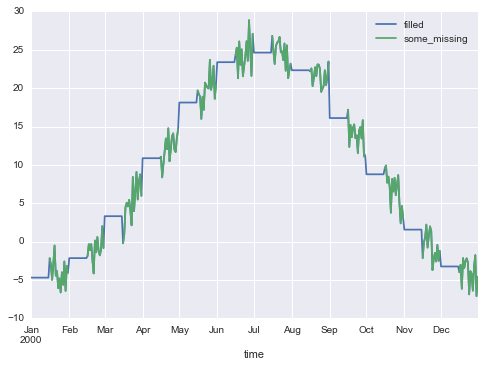

In [23]:
df[['filled', 'some_missing']].plot()